In [1]:
!nvidia-smi

Mon Oct 30 07:12:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8               4W /  30W |      6MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#%%capture
#%pip uninstall torchaudio
#%pip install -U torch torchvision torchdata --index-url https://download.pytorch.org/whl/cu118
#%pip install -U lightning
#%pip install wandb
#%pip install python-dotenv

In [3]:
import os

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight

import torch
import torchvision
import torchmetrics

import torchdata.datapipes as dp
from torch.utils.data import DataLoader
torchvision.disable_beta_transforms_warning();

from torchvision.models import AlexNet 
import torchvision.transforms.v2 as t

from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, WandbLogger

import wandb

from tqdm import tqdm
from typing import Callable
from dotenv import load_dotenv
load_dotenv();

from hyperparameters import Hyperparameters
from datamodules import ImagenetteDataModule

#import logging
#logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
#logging.getLogger("wandb").setLevel(logging.WARNING)

os.environ["WANDB_NOTEBOOK_NAME"] = (Path.cwd() / "experiments.ipynb").as_posix()

In [4]:
IMAGENETTE = Path.home() / "datasets" / "imagenette"

CHECKPOINTS_DIR = Path.cwd() / "checkpoints"
CHECKPOINTS_DIR.mkdir(exist_ok=True)

LOGS_DIR = Path.cwd() / "logs"
LOGS_DIR.mkdir(exist_ok=True)

In [5]:
class ClassificationModel(LightningModule):
    def __init__(self, model, params: Hyperparameters):
        super().__init__()
        self.model = model

        #TODO : Add dicts for Metrics, Optimizers, Criterions
        self.task = params.task
        self.num_classes = params.num_classes
        self.criterion = params.criterion
        self.optimizer = params.optimizer
        self.learning_rate = params.learning_rate
        self.momentum = params.momentum
        self.weight_decay = params.weight_decay

        self._set_metrics()
        self.save_hyperparameters(
            {i:params.get_litmodule_hparams()[i] 
             for i in params.get_litmodule_hparams().keys() if i!='criterion'},
            ignore = ["model", "params"]
        ) 

    def forward(self, batch):
        x, _ = batch
        return self.model(x)

    def _forward_pass(self, batch, metrics : Callable | None = None) -> tuple:
        x, y = batch
        y_pred = self.model(x)
        if metrics:
            metrics.update(y_pred, y) 
        return self.criterion(y_pred, y), y_pred #type: ignore

    def _set_metrics(self):
        metrics = {"accuracy": torchmetrics.Accuracy(
                                task="multiclass",
                                num_classes=self.num_classes, 
                                average="macro"),

                   "f1" : torchmetrics.F1Score(
                                task="multiclass",
                                num_classes=self.num_classes,
                                average="macro")
                  }

        self.val_metrics = torchmetrics.MetricCollection(
            metrics=metrics.copy(), prefix = "val_"
        )
        self.test_metrics = torchmetrics.MetricCollection(
            metrics=metrics.copy(), prefix = "test_"
        )
        self.test_confm = torchmetrics.ConfusionMatrix(
            task = "multiclass", num_classes = self.num_classes,
        )

    def training_step(self, batch, batch_idx):
        loss, _ = self._forward_pass(batch)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, _ = self._forward_pass(batch, self.val_metrics)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        #self.log_dict(self.val_metrics, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        _, y = batch
        _, y_pred = self._forward_pass(batch)
        self.test_metrics.update(y_pred, y)
        self.test_confm.update(y_pred, y)
    
    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

        self.test_confm.compute()
        self.test_confm.plot()
        plt.show()
        self.test_confm.reset()

    def configure_optimizers(self):
        return self.optimizer(params = self.model.parameters(),
                              lr = self.learning_rate,
                              momentum = self.momentum, 
                              weight_decay = self.weight_decay)

In [6]:
local_checkpoint = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="{epoch}-{train_loss:2f}-{val_loss:2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
)

local_logger = CSVLogger(
    save_dir=Path.cwd(),
    name="logs",
    version=1,
)

#wandb.finish()
#wandb_logger = WandbLogger(
    #save_dir=LOGS_DIR,
    #project="ilsvrc",
    #log_model=True,
    #name="alexnet",
    #version='1',
#)

In [8]:
#.setup("test")
#weights = imagenette_dm.train_df.label.value_counts().sort_index()
#weights = weights.sum() / weights
#weights = torch.tensor(weights.to_list(), dtype = torch.float32)
#weights = weights / weights.sum()
##weights = torch.nn.functional.softmax(weights, dim = 0)
#print(weights)

In [13]:
#imagenette_class_weights = torch.tensor([0.0982, 0.0990, 0.0952, 0.1102, 0.1005, 0.0989, 0.0984, 0.1016, 0.0994, 0.0985])
#imagenette_class_weights = torch.tensor([0.0765, 0.0830, 0.0568, 0.2547, 0.0962, 0.0822, 0.0780, 0.1072, 0.0866, 0.0788])

experiment = Hyperparameters(
    task = "multiclass_classification",
    random_seed = 42,
    num_classes = 10,
    metrics = ["accuracy", "f1"],

    criterion = torch.nn.CrossEntropyLoss(),#weight=imagenette_class_weights),
    optimizer = torch.optim.SGD,
    learning_rate = 1e-2,
    momentum = 0.9,
    weight_decay = 5e-4,

    batch_size = 128,
    grad_accum = 4,
    test_split = .3,
    transform = ["scale_[0,1]", "resize_256", "random_crop_224", "normalize", "hflip"],
    num_workers = 8,
)
seed_everything(experiment.random_seed);
alexnet = AlexNet(num_classes = experiment.num_classes, dropout= 0.5)
alexnet_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale = True),
    t.Resize(size = (256, 256), antialias = True),
    t.RandomCrop(size = (224, 224), pad_if_needed = True),
    t.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    t.RandomHorizontalFlip(p = .5)
])
imagenette_dm = ImagenetteDataModule(
        root = IMAGENETTE, 
        params = experiment, 
        transform = alexnet_transform)


Seed set to 42


In [15]:
trainer = Trainer(
    #fast_dev_run=True,
    #num_sanity_val_steps=10,
    #limit_train_batches=.5,
    #deterministic=True,
    #benchmark=True,
    #enable_checkpointing=False,
    callbacks=[local_checkpoint],
    logger=[local_logger],#, wandb_logger],

    max_epochs = 8,
    accumulate_grad_batches = experiment.grad_accum,
    check_val_every_n_epoch = 1
)

last_ckpt = CHECKPOINTS_DIR / "last.ckpt"
last_ckpt = last_ckpt if last_ckpt.is_file() else None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(
    model=ClassificationModel(alexnet, experiment),
    datamodule=imagenette_dm,
    ckpt_path=last_ckpt #type: ignore
)

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sambhav/dev/ilsvrc/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/sambhav/dev/ilsvrc/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | model        | AlexNet                   | 57.0 M
1 | criterion    | CrossEntropyLoss          | 0     
2 | val_metrics  | MetricCollection          | 0     
3 | test_metrics | MetricCollection          | 0     
4 | test_confm   | MulticlassConfusionMatrix | 0     
-----------------------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.179   Total estimated model params size (MB)
Restored all states from the checkpoint at /home/sambhav/dev/ilsvrc/checkpoints/last.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


Restoring states from the checkpoint path at /home/sambhav/dev/ilsvrc/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/sambhav/dev/ilsvrc/checkpoints/last.ckpt
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

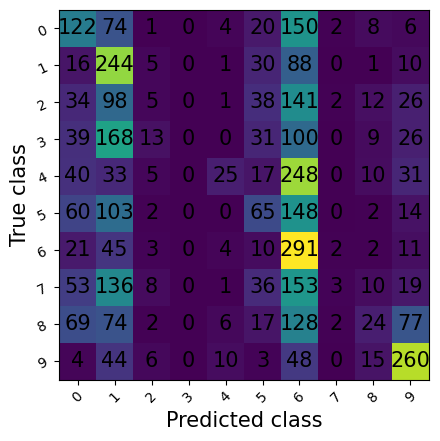

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.265512079000473     │
│          test_f1          │    0.1981712132692337     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.265512079000473, 'test_f1': 0.1981712132692337}]

In [17]:
trainer.test(
    model=ClassificationModel(alexnet, experiment),
    datamodule=imagenette_dm,
    ckpt_path=last_ckpt,
)

In [16]:
dm = imagenette_dm
dm.setup("fit")
dl = imagenette_dm.train_dataloader()

In [18]:
labels = list()
for batch in dl:
    labels += batch[1].tolist()

In [26]:
labels_s = pd.Series(labels).value_counts()
label_dist = labels_s.sort_index().to_list()
label_dist

In [30]:
label_dist_t = torch.tensor(label_dist, dtype = torch.float)
label_biases = torch.softmax(label_dist_t, dim = 0)
label_biases

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
wandb.finish()